## Import Libraries

In [1]:
import numpy as np
from random import sample
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import math
import collections

## Import the Reward and Transition Matrix from the xls file

In [2]:
#Import the reward table and the transition matrix
r_table = pd.read_excel('environment_matrices.xlsx', sheet_name ='rewards', index_col=0)
state_value_function = pd.read_excel('environment_matrices.xlsx', sheet_name ='State value function')
transition_matrix = pd.read_excel('environment_matrices.xlsx', sheet_name ='transition',index_col=0)

## Initialize important parameters and Q matrix

In [3]:
#Initialize parameters
total_episodes = 10000 #Total episodes
number_of_steps = 100 #Maximum steps per episode
T = 0.5 #For the Boltzamann's formula

#Q Learning parameters
alpha = 0.2 #Learning rate
gamma = 0.99 #Discount rate

#Initialization of the Q matrix
q_table = pd.DataFrame(np.matrix(np.zeros([16,4])).astype("float32"), columns = transition_matrix.columns, index = transition_matrix.index)
q_table.head()

,UP,DOWN,RIGHT,LEFT
A,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0


In [4]:
#%% Define the optimal state value table
optimal_state_value_function = np.array(state_value_function)
optimal_state_value_function

# plot_values(optimal_state_value_function)

array([[-6, -5, -4, -5],
       [-5,  0, -3,  0],
       [-4, -3, -2,  0],
       [ 0, -2, -1,  0]], dtype=int64)

## Boltzmann (softmax) policy function


In [5]:
e = 2.71828 #Source : https://en.wikipedia.org/wiki/E_(mathematical_constant)

def softmax_policy(state, T):
    
    #Initialize Vectors with max length = 4, based on the avaliable number of moves  
    action_vector = deque(maxlen=4)
    action_nominator = deque(maxlen=4)
    action_probability_distribution_vector = deque(maxlen=4)
    
    actions_list = ["UP", "DOWN", "RIGHT", "LEFT"]
  
    action_vector = q_table.loc[state, :] # Vector of the Q matrix based on my current state
    print("Action Vector from Q Table", action_vector)
    
    
    #Map every element of the vector to a value of e ^ action_vector[i]/T, where action_vector[i] = Q[i] (4 actions)
    sum_denominator = 0 # initialize summary for the calculation of the formula
    for i in range(4):
        action_nominator.append(e**(action_vector[i]/T)) # Calculate action nominator value
        sum_denominator += e**(action_vector[i]/T) # Add the value to the summary
    
    print("Action Nominator: ", action_nominator)
    print("Sum Denominator", sum_denominator)
    
    print("SIZE Action Nominator: ", action_nominator.maxlen)

                               
    #Calculate the probability distribution                          
    for i in range(4):
        action_probability_distribution_vector.append(action_nominator[i]/sum_denominator) #Append value in the vector
    
    print("Action Probability Distribution: ", action_probability_distribution_vector)

    
    rand_val = np.random.uniform(0, 1)
    prob_sum = 0
    for i, prob in enumerate(action_probability_distribution_vector):
        prob_sum += prob
        if rand_val <= prob_sum:
            action = i # Based on the probability dirstribution, return the number of action 0-3
            break
            
    action = str(action) #Convert the integer action value to string
    
    #Map the numerical value to the action 
    if (action == '0'):
        action = action.replace('0', 'UP')
    elif (action == '1'):
        action = action.replace('1','DOWN')
    elif (action== '2'):
        action = action.replace('2', 'RIGHT')
    else:
        action = action.replace('3', 'LEFT')
    
    
    print("Action", action)
    
    return action


##  'execute_action' Function

In [6]:
# Execution of the action selected from policy.
def execute_action(state, action):
    next_state = transition_matrix.loc[state,action] #return the next state
    reward = r_table.loc[state, next_state]
    end_episode_states = ['F', 'H', 'L', 'M', 'P']
    done = False #done is a flag to determine if my algorithm is going to terminate or not
    if (next_state in end_episode_states):
        done = True
    print('Current state', state)
    print('Next state', next_state)
    print ('Done', done)
    
    
    return next_state, reward, done

## 'update_Q' Function

In [7]:
#Update Q
def update_Q(current_state, next_state, action, reward, alpha, gamma):
    q_old = q_table.loc[current_state, action] #OLD Q value
    q_new = q_old + alpha * (reward + gamma * max(q_table.loc[next_state,:] - q_old))
    #q_new_values.append(q_new) # # add the new q value to a list with all the q new values
    q_table.loc[current_state, action] = q_new
    
    print('Old Q value:       ', q_old)
    print('Updated Q value (Q new): ', q_new)

## Train the Agent

In [8]:
#Training the agent
sum_reward = 0
#episodes_rewards_list_per_10 = []


#Main
episodes_rewards_list = []
window = 100
# initialize average rewards
average_reward = deque(maxlen=total_episodes)
# initialize best average reward as negative infinity
best_average_reward = -math.inf
# initialize monitor for most recent rewards
check_rewards = deque(maxlen=window)

#EPISODES
for episode in range(1, total_episodes + 1):
    current_state = 'A'
    episode_reward = 0
    # Decide the value of epsilon before the start of the episode
    for step in range (number_of_steps):
        #Choose action depending on the value of epsilon
        action = softmax_policy(current_state, T)
        
        #Execute Action and calculate the next state, the reward and check if the episode is finished
        next_state, reward, done = execute_action(current_state, action)
        
        # Update the Q Matrix based on the new values
        update_Q(current_state, next_state, action, reward, alpha, gamma)
        current_state = next_state
        
        episode_reward += reward 
        
        if done:
            check_rewards.append(episode_reward)
            break

    if episode >= 100:
        average_reward = np.mean(check_rewards)
        if average_reward > best_average_reward:
            best_average_reward = average_reward
    print("\rEpisode {}/{} || Best average reward {}".format(episode, total_episodes, best_average_reward), end="")

    
    if best_average_reward > 83:
        print('\nThe environment is solved in {} episodes.'.format(episode-1), end = "")
        break
    
    episodes_rewards_list.append(episode_reward)
    print("\rThe reward for this episode is: {}".format(episode_reward))
    
    episode_reward = 0


Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: A, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.25, 0.25, 0.25, 0.25], maxlen=4)
Action RIGHT
Current state A
Next state B
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: B, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.25, 0.25, 0.25, 0.25], maxlen=4)
Action RIGHT
Current state B
Next state C
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: C, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probabi

Action RIGHT
Current state B
Next state C
Done False
Old Q value:        -0.3604
Updated Q value (Q new):  -0.4890407930016518
Action Vector from Q Table UP      -0.2000
DOWN     0.0000
RIGHT   -0.2000
LEFT    -0.3604
Name: C, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 0.6703202223972867, 0.4863632541747484], maxlen=4)
Sum Denominator 2.8270036989693215
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.2371133163503374, 0.3537314084040935, 0.2371133163503374, 0.17204195889523186], maxlen=4)
Action RIGHT
Current state C
Next state D
Done False
Old Q value:        -0.2
Updated Q value (Q new):  -0.36040000239014625
Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT   -0.2
LEFT    -0.2
Name: D, dtype: float32
Action Nominator:  deque([1.0, 1.0, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 3.3406404447945732
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.2993437984498488, 0.2993437984498488, 0.200

Done False
Old Q value:        -0.85857004
Updated Q value (Q new):  -1.005830892086029
Action Vector from Q Table UP       -0.600000
DOWN    -20.000000
RIGHT    -0.592211
LEFT     -0.948533
Name: B, dtype: float32
Action Nominator:  deque([0.3011944406691658, 4.248468563510848e-18, 0.30592337300870415, 0.15000832556811888], maxlen=4)
Sum Denominator 0.7571261392459887
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.3978127620440117, 5.6113087942543344e-18, 0.40405865964866694, 0.1981285783073215], maxlen=4)
Action LEFT
Current state B
Next state A
Done False
Old Q value:        -0.9485329
Updated Q value (Q new):  -1.0858218927383423
Action Vector from Q Table UP      -0.874912
DOWN    -0.631811
RIGHT   -1.005831
LEFT    -0.920843
Name: A, dtype: float32
Action Nominator:  deque([0.17380485105883128, 0.2826288858072819, 0.13376638248871936, 0.15854996689427311], maxlen=4)
Sum Denominator 0.7487500862491057
SIZE Action Nominator:  4
Action Probability Distribution:

Done False
Old Q value:        -0.5922107
Updated Q value (Q new):  -0.7463121877312661
Action Vector from Q Table UP       -0.495278
DOWN    -20.000000
RIGHT    -0.360400
LEFT     -0.360400
Name: I, dtype: float32
Action Nominator:  deque([0.37137070852700876, 4.248468563510848e-18, 0.4863632541747484, 0.4863632541747484], maxlen=4)
Sum Denominator 1.3440972168765055
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.27629750576377393, 3.160834283537687e-18, 0.36185124711811306, 0.36185124711811306], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        -0.3604
Updated Q value (Q new):  -0.4890407930016518
Action Vector from Q Table UP      -20.0
DOWN      0.0
RIGHT     0.0
LEFT     -0.2
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 1.0, 1.0, 0.6703202223972867], maxlen=4)
Sum Denominator 2.6703202223972866
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.5909959142266371e-18, 0.3744869216854

Updated Q value (Q new):  -0.966655163884163
Action Vector from Q Table UP       -1.047925
DOWN     -0.969020
RIGHT   -20.000000
LEFT     -0.895329
Name: E, dtype: float32
Action Nominator:  deque([0.12296573560451544, 0.14398598500456716, 4.248468563510848e-18, 0.1668505076795982], maxlen=4)
Sum Denominator 0.4338022282886808
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.28346035955049514, 0.3319161950195178, 9.79356095119833e-18, 0.384623445429987], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        -0.9690203
Updated Q value (Q new):  -1.073984363079071
Action Vector from Q Table UP       -0.966655
DOWN    -20.000000
RIGHT    -0.489041
LEFT     -0.560400
Name: I, dtype: float32
Action Nominator:  deque([0.14466870122766398, 4.248468563510848e-18, 0.37603204014634295, 0.32601911498816505], maxlen=4)
Sum Denominator 0.846719856362172
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.17085781104651934, 5.017561040

Current state E
Next state I
Done False
Old Q value:        -1.1581656
Updated Q value (Q new):  -1.2461065109968186
Action Vector from Q Table UP       -1.152533
DOWN    -20.000000
RIGHT    -0.592211
LEFT     -0.746271
Name: I, dtype: float32
Action Nominator:  deque([0.09975245574467659, 4.248468563510848e-18, 0.30592337300870415, 0.22480075868247526], maxlen=4)
Sum Denominator 0.630476587435856
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.15821754167013424, 6.738503297623375e-18, 0.48522558823776857, 0.3565568700920972], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        -0.5922107
Updated Q value (Q new):  -0.7145529870986939
Action Vector from Q Table UP      -20.0
DOWN     -0.2
RIGHT    -0.2
LEFT     -0.2
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 0.6703202223972867, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 2.0109606671918603
SIZE Action Nominator:  4
Action Probability

Action Nominator:  deque([0.016898333076560173, 0.023272677364435054, 0.026201668592724908, 0.018019266862360956], maxlen=4)
Sum Denominator 0.08439194589608108
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.20023632465316674, 0.2757689388166575, 0.3104759383672612, 0.21351879816291472], maxlen=4)
Action DOWN
Current state A
Next state E
Done False
Old Q value:        -1.8802389
Updated Q value (Q new):  -1.9644267745018005
Action Vector from Q Table UP       -1.960278
DOWN     -1.416850
RIGHT   -20.000000
LEFT     -1.295329
Name: E, dtype: float32
Action Nominator:  deque([0.01983010291692523, 0.05879498300309335, 4.248468563510848e-18, 0.07497079182201326], maxlen=4)
Sum Denominator 0.15359587774203182
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.12910569742132266, 0.38279011043409, 2.766004287332671e-17, 0.48810419214458745], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        -1.4168503
Updated Q value (Q n

Name: C, dtype: float32
Action Nominator:  deque([0.14648991703467198, 0.2097532352162811, 0.0833800945686203, 0.08238631194499281], maxlen=4)
Sum Denominator 0.5220095587645661
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.2806268861845518, 0.4018187630753383, 0.15972905700415715, 0.1578252937359529], maxlen=4)
Action RIGHT
Current state C
Next state D
Done False
Old Q value:        -1.2421737
Updated Q value (Q new):  -1.4244299986362456
Action Vector from Q Table UP       -1.172987
DOWN    -20.000000
RIGHT    -1.152559
LEFT     -1.196272
Name: D, dtype: float32
Action Nominator:  deque([0.09575406935228778, 4.248468563510848e-18, 0.09974715231618621, 0.09139699667383118], maxlen=4)
Sum Denominator 0.28689821834230517
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.33375623559307466, 1.480827796024128e-17, 0.3476743525718779, 0.31856941183504744], maxlen=4)
Action LEFT
Current state D
Next state C
Done False
Old Q value:        -1.1962721
U

Action Probability Distribution:  deque([0.35766544885469365, 1.5869094921936684e-17, 0.37258061455216734, 0.269753936593139], maxlen=4)
Action RIGHT
Current state D
Next state D
Done False
Old Q value:        -1.1525592
Updated Q value (Q new):  -1.3525591611862182
Action Vector from Q Table UP       -1.172987
DOWN    -20.000000
RIGHT    -1.352559
LEFT     -1.314031
Name: D, dtype: float32
Action Nominator:  deque([0.09575406935228778, 4.248468563510848e-18, 0.06686252734610994, 0.07221842991908863], maxlen=4)
Sum Denominator 0.23483502661748634
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.40775037153319493, 1.809128997792571e-17, 0.28472127139287323, 0.30752835707393184], maxlen=4)
Action LEFT
Current state D
Next state C
Done False
Old Q value:        -1.3140309
Updated Q value (Q new):  -1.4450820175409318
Action Vector from Q Table UP      -1.124861
DOWN    -0.965804
RIGHT   -1.570600
LEFT    -1.505798
Name: C, dtype: float32
Action Nominator:  deque([0.105

Action Nominator:  deque([0.005529840029255503, 0.013289599313657821, 0.010090444620618925, 0.007143385977268866], maxlen=4)
Sum Denominator 0.036053269940801116
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.15337970836862816, 0.36861009654544863, 0.27987599008875674, 0.1981342049971664], maxlen=4)
Action DOWN
Current state A
Next state E
Done False
Old Q value:        -2.1603882
Updated Q value (Q new):  -2.183216094970703
Action Vector from Q Table UP       -2.162032
DOWN     -1.265579
RIGHT   -20.000000
LEFT     -1.691170
Name: E, dtype: float32
Action Nominator:  deque([0.01324599028308045, 0.07956689047159292, 4.248468563510848e-18, 0.03396793136874177], maxlen=4)
Sum Denominator 0.12678081212341513
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.10447945600936918, 0.6275941062290902, 3.3510343500364746e-17, 0.26792643776154074], maxlen=4)
Action UP
Current state E
Next state A
Done False
Old Q value:        -2.1620317
Updated Q value (Q

Action Probability Distribution:  deque([0.0009079818300277762, 0.9955891577301771, 4.381130042711223e-19, 0.00350286043979498], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        1.133709
Updated Q value (Q new):  2.7947334575653078
Action Vector from Q Table UP       -1.301606
DOWN    -20.000000
RIGHT    10.532823
LEFT     -1.247207
Name: I, dtype: float32
Action Nominator:  deque([0.0740354797996995, 4.248468563510848e-18, 1408274521.0749576, 0.08254501817972673], maxlen=4)
Sum Denominator 1408274521.231538
SIZE Action Nominator:  4
Action Probability Distribution:  deque([5.2571766856191766e-11, 3.0167900501356484e-27, 0.9999999998888139, 5.861429496540277e-11], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        10.532823
Updated Q value (Q new):  14.680181861877442
Action Vector from Q Table UP      -20.000000
DOWN     32.489182
RIGHT    -0.200000
LEFT     -0.200000
Name: J, dtype: float32
Action Nominator:  deque([4.2

Name: O, dtype: float32
Action Nominator:  deque([1.0, 1.0, 4.7303497599848765e+85, 1.0], maxlen=4)
Sum Denominator 4.7303497599848765e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([2.114008584437522e-86, 2.114008584437522e-86, 1.0, 2.114008584437522e-86], maxlen=4)
Action RIGHT
Current state O
Next state P
Done True
Old Q value:        98.63693
Updated Q value (Q new):  99.1068197631836
The reward for this episode is: 95.0
Action Vector from Q Table UP      -2.720139
DOWN     3.015554
RIGHT   -2.463161
LEFT    -2.617472
Name: A, dtype: float32
Action Nominator:  deque([0.004338290637840302, 416.17396953899953, 0.0072531623721246935, 0.005327142262720074], maxlen=4)
Sum Denominator 416.19088813427226
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.042380013961448e-05, 0.9999593489531965, 1.7427489594113038e-05, 1.2799757069648824e-05], maxlen=4)
Action DOWN
Current state A
Next state E
Done False
Old Q value:        3.0155537
Updated Q value

SIZE Action Nominator:  4
Action Probability Distribution:  deque([3.643776014496154e-49, 2.0909525935326742e-65, 1.0, 4.062586724272948e-49], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        54.465256
Updated Q value (Q new):  58.879949432373046
Action Vector from Q Table UP      -20.00000
DOWN     77.77179
RIGHT    -0.20000
LEFT     -0.20000
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 3.561825677430824e+67, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 3.561825677430824e+67
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.1927783525260298e-85, 1.0, 1.88195684770512e-68, 1.88195684770512e-68], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        77.77179
Updated Q value (Q new):  80.70319477844238
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    93.586967
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0

Old Q value:        56.535465
Updated Q value (Q new):  60.27134290313721
Action Vector from Q Table UP       -1.301606
DOWN    -20.000000
RIGHT    76.413635
LEFT     -1.247207
Name: I, dtype: float32
Action Nominator:  deque([0.0740354797996995, 4.248468563510848e-18, 2.3550255355405362e+66, 0.08254501817972673], maxlen=4)
Sum Denominator 2.3550255355405362e+66
SIZE Action Nominator:  4
Action Probability Distribution:  deque([3.143723016264728e-68, 1.8040010604537755e-84, 1.0, 3.5050583076068693e-68], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        76.413635
Updated Q value (Q new):  79.02735102844238
Action Vector from Q Table UP      -20.000000
DOWN     90.624321
RIGHT    -0.200000
LEFT     -0.200000
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 5.190773884970693e+78, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 5.190773884970693e+78
SIZE Action Nominator:  4
Action Probability Distribution:  deque(

Name: I, dtype: float32
Action Nominator:  deque([0.0740354797996995, 4.248468563510848e-18, 6.524375935650673e+76, 0.08254501817972673], maxlen=4)
Sum Denominator 6.524375935650673e+76
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.1347518985709087e-78, 6.511685723528361e-95, 1.0, 1.265178754165314e-78], maxlen=4)
Action RIGHT
Current state I
Next state J
Done False
Old Q value:        88.436066
Updated Q value (Q new):  89.71745529174805
Action Vector from Q Table UP      -20.000000
DOWN     95.917831
RIGHT    -0.200000
LEFT     -0.200000
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 2.0564292078979195e+83, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 2.0564292078979195e+83
SIZE Action Nominator:  4
Action Probability Distribution:  deque([2.065944476568503e-101, 1.0, 3.2596318892128922e-84, 3.2596318892128922e-84], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        95.91783
Updated 

Name: A, dtype: float32
Action Nominator:  deque([0.004338290637840302, 9.66373083354415e+64, 0.0072531623721246935, 0.005327142262720074], maxlen=4)
Sum Denominator 9.66373083354415e+64
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.489250282904707e-68, 1.0, 7.505550906848481e-68, 5.512511010994661e-68], maxlen=4)
Action DOWN
Current state A
Next state E
Done False
Old Q value:        74.81696
Updated Q value (Q new):  76.9696830291748
Action Vector from Q Table UP       -2.366226
DOWN     86.699387
RIGHT   -20.000000
LEFT     -1.691170
Name: E, dtype: float32
Action Nominator:  deque([0.008804879616686424, 2.023390524157141e+75, 4.248468563510848e-18, 0.03396793136874177], maxlen=4)
Sum Denominator 2.023390524157141e+75
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.351547321965523e-78, 1.0, 2.099677997296434e-93, 1.6787629952399514e-77], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        86.69939
Updated Q va

Action Nominator:  deque([4.248468563510848e-18, 3.364367888843736e+85, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 3.364367888843736e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.2627835908191834e-103, 1.0, 1.9924105940378062e-86, 1.9924105940378062e-86], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.46655
Updated Q value (Q new):  98.55367630004883
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.916672
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 6.115894817098444e+86, 1.0], maxlen=4)
Sum Denominator 6.115894817098444e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.6350837120420405e-87, 1.0960296774942018e-87, 1.0, 1.6350837120420405e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.91667
Updated Q value (Q new):  99.93195626831054
Action Vector from Q T

Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 6.308524305344316e+85, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 6.308524305344316e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([6.734488697953853e-104, 1.0, 1.0625626373974967e-86, 1.0625626373974967e-86], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.78088
Updated Q value (Q new):  98.81629580688477
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.969833
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 6.801983498461008e+86, 1.0], maxlen=4)
Sum Denominator 6.801983498461008e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.4701594031009577e-87, 9.854775780460964e-88, 1.0, 1.4701594031009577e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.96983
Updated Q value (Q new):  99.97540309143066


Action Probability Distribution:  deque([5.0795053321560423e-104, 1.0, 8.014405880657631e-87, 8.014405880657631e-87], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.9219
Updated Q value (Q new):  98.93361431884766
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.991173
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.098567938485382e+86, 1.0], maxlen=4)
Sum Denominator 7.098567938485382e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.4087348443598463e-87, 9.443034541700993e-88, 1.0, 1.4087348443598463e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.99117
Updated Q value (Q new):  99.99281338500977
Action Vector from Q Table UP         0.00000
DOWN       0.00000
RIGHT    101.00956
LEFT       0.00000
Name: O, dtype: float32
Action Nominator:  deque([1.0, 1.0, 5.441638897963103e+87, 1.0], maxlen=4)
Sum Denomin

Old Q value:        97.88065
Updated Q value (Q new):  97.89673701477051
Action Vector from Q Table UP      -20.000000
DOWN     98.971985
RIGHT    -0.200000
LEFT     -0.200000
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 9.245192387495973e+85, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 9.245192387495973e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.595327371723338e-104, 1.0, 7.250473481805396e-87, 7.250473481805396e-87], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.971985
Updated Q value (Q new):  98.97511946105956
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.997917
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.194967514771483e+86, 1.0], maxlen=4)
Sum Denominator 7.194967514771483e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.3898603405046239e-87, 9.316514925482

Action DOWN
Current state A
Next state E
Done False
Old Q value:        95.35499
Updated Q value (Q new):  95.43962367248535
Action Vector from Q Table UP       -2.366226
DOWN     96.792542
RIGHT   -20.000000
LEFT     -1.691170
Name: E, dtype: float32
Action Nominator:  deque([0.008804879616686424, 1.1827059377667384e+84, 4.248468563510848e-18, 0.03396793136874177], maxlen=4)
Sum Denominator 1.1827059377667384e+84
SIZE Action Nominator:  4
Action Probability Distribution:  deque([7.444690464066127e-87, 1.0, 3.592159663570372e-102, 2.8720521546448147e-86], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        96.79254
Updated Q value (Q new):  96.81956806945801
Action Vector from Q Table UP       -1.301606
DOWN    -20.000000
RIGHT    97.939140
LEFT     -1.247207
Name: I, dtype: float32
Action Nominator:  deque([0.0740354797996995, 4.248468563510848e-18, 1.1716534743626443e+85, 0.08254501817972673], maxlen=4)
Sum Denominator 1.1716534743626443e+85
SIZE Action 

Current state A
Next state E
Done False
Old Q value:        95.63076
Updated Q value (Q new):  95.67786138916016
Action Vector from Q Table UP       -2.366226
DOWN     96.878746
RIGHT   -20.000000
LEFT     -1.691170
Name: E, dtype: float32
Action Nominator:  deque([0.008804879616686424, 1.4052481725102892e+84, 4.248468563510848e-18, 0.03396793136874177], maxlen=4)
Sum Denominator 1.4052481725102892e+84
SIZE Action Nominator:  4
Action Probability Distribution:  deque([6.26571148707326e-87, 1.0, 3.023287022620014e-102, 2.4172193946399216e-86], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        96.878746
Updated Q value (Q new):  96.89285075378417
Action Vector from Q Table UP       -1.301606
DOWN    -20.000000
RIGHT    97.960083
LEFT     -1.247207
Name: I, dtype: float32
Action Nominator:  deque([0.0740354797996995, 4.248468563510848e-18, 1.2217708526780719e+85, 0.08254501817972673], maxlen=4)
Sum Denominator 1.2217708526780719e+85
SIZE Action Nominator:  

Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.98847
Updated Q value (Q new):  98.98872583007812
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.999855
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.222907373582926e+86, 1.0], maxlen=4)
Sum Denominator 7.222907373582926e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.384484042613369e-87, 9.28047651350088e-88, 1.0, 1.384484042613369e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.999855
Updated Q value (Q new):  99.99988078308105
Action Vector from Q Table UP         0.000000
DOWN       0.000000
RIGHT    101.010086
LEFT       0.000000
Name: O, dtype: float32
Action Nominator:  deque([1.0, 1.0, 5.447371175797362e+87, 1.0], maxlen=4)
Sum Denominator 5.447371175797362e+87
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.8357478639292914e-88, 1.83574

Current state I
Next state J
Done False
Old Q value:        97.97668
Updated Q value (Q new):  97.97720571899414
Action Vector from Q Table UP      -20.000000
DOWN     98.989449
RIGHT    -0.200000
LEFT     -0.200000
Name: J, dtype: float32
Action Nominator:  deque([4.248468563510848e-18, 9.573807834698482e+85, 0.6703202223972867, 0.6703202223972867], maxlen=4)
Sum Denominator 9.573807834698482e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.43759540285848e-104, 1.0, 7.001605149915753e-87, 7.001605149915753e-87], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.98945
Updated Q value (Q new):  98.98952716064453
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.999947
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.224230047624332e+86, 1.0], maxlen=4)
Sum Denominator 7.224230047624332e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([

Sum Denominator 9.579214491578406e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.435090755349409e-104, 1.0, 6.997653335632067e-87, 6.997653335632067e-87], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.98973
Updated Q value (Q new):  98.98975808715821
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.999969
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.224560753978399e+86, 1.0], maxlen=4)
Sum Denominator 7.224560753978399e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.3841671958386161e-87, 9.278352625495699e-88, 1.0, 1.3841671958386161e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.99997
Updated Q value (Q new):  99.99997256469726
Action Vector from Q Table UP         0.000000
DOWN       0.000000
RIGHT    101.010086
LEFT       0.000000
Name: O, dtype: float32
Action Nominator: 

Sum Denominator 9.581114852548788e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.434211079706097e-104, 1.0, 6.996265389919282e-87, 6.996265389919282e-87], maxlen=4)
Action DOWN
Current state J
Next state N
Done False
Old Q value:        98.98983
Updated Q value (Q new):  98.98983763122558
Action Vector from Q Table UP        0.000000
DOWN     -0.200000
RIGHT    99.999969
LEFT      0.000000
Name: N, dtype: float32
Action Nominator:  deque([1.0, 0.6703202223972867, 7.224560753978399e+86, 1.0], maxlen=4)
Sum Denominator 7.224560753978399e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.3841671958386161e-87, 9.278352625495699e-88, 1.0, 1.3841671958386161e-87], maxlen=4)
Action RIGHT
Current state N
Next state O
Done False
Old Q value:        99.99997
Updated Q value (Q new):  99.99997256469726
Action Vector from Q Table UP         0.000000
DOWN       0.000000
RIGHT    101.010086
LEFT       0.000000
Name: O, dtype: float32
Action Nominator: 

# Calculate Average Rewards per 100 Episodes

In [9]:
sum_rewards = 0
avg_rewards_per_50 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%50) == 0 :
        avg_rewards_per_50.append(sum_rewards/50)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%50==0):
            break
        else:
            avg_rewards_per_50.append(sum_rewards/(i%50))
        
avg_rewards_per_50

[59.48, 95.0, 95.0]

In [10]:
df = pd.DataFrame()
df = df.fillna(0)
df['Avg_Reward'] = avg_rewards_per_50
df['Episodes'] = (df.index+1)*50

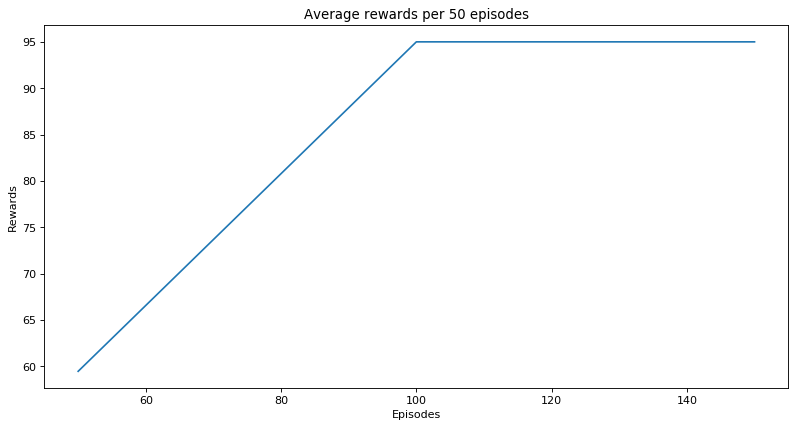

In [11]:
#Plot the average rewards per 50 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 50 episodes')
plt.plot(df['Episodes'], df['Avg_Reward'])

# Calculate Average Rewards per 10 Episodes

In [12]:
sum_rewards = 0
avg_rewards_per_10 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%10) == 0 :
        avg_rewards_per_10.append(sum_rewards/10)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%10==0):
            break
        else:
            avg_rewards_per_10.append(sum_rewards/(i%10))
        
avg_rewards_per_10

len(avg_rewards_per_10)

11

In [13]:
df_10 = pd.DataFrame()
df_10 = df_10.fillna(0)
df_10['Avg_Reward'] = avg_rewards_per_10
df_10['Episodes'] = (df_10.index+1)*10


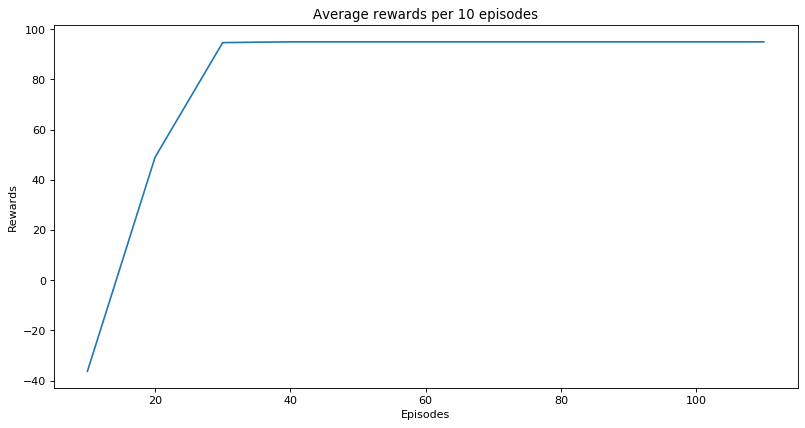

In [14]:
#Plot the average rewards per 10 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 10 episodes')
plt.plot(df_10['Episodes'], df_10['Avg_Reward'])

# Calculate Reward per episode

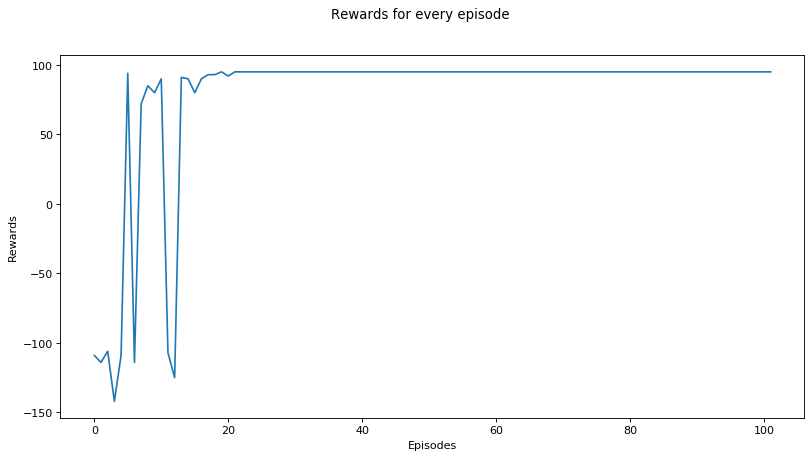

In [15]:
#%% Plot the reward for every episode
reward_per_episode = pd.DataFrame(np.asarray(episodes_rewards_list)) 
reward_per_episode['episodes'] = reward_per_episode.index
reward_per_episode.columns = ['total_reward', 'episodes']


plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.suptitle('Rewards for every episode')
plt.plot(reward_per_episode['episodes'], reward_per_episode['total_reward'])